# implement autoencoder based on lstm, cnn and dense layers

When working with time series data, using dense layers (fully connected layers) with an input size equal to the sequence length is generally not ideal for several reasons:

1. Loss of Temporal Dependencies
Time series data has an inherent sequential nature where the order and timing of data points matter. Dense layers treat each input feature independently, ignoring the temporal dependencies between consecutive time points. This can lead to poor performance in capturing the patterns and relationships that are crucial in time series data.

2. Fixed Input Size
Dense layers require a fixed input size, meaning the model architecture is rigid and cannot easily adapt to sequences of varying lengths. In many real-world applications, time series data can have varying lengths, necessitating a more flexible approach.

3. Parameter Inefficiency
Dense layers with a large input size result in a vast number of parameters, making the model computationally expensive and prone to overfitting, especially when the sequence length is long. This inefficiency can be a significant drawback when working with high-dimensional time series data.

4. Ineffective for Long-Term Dependencies
Dense layers are not well-suited for capturing long-term dependencies within the data. Techniques like Recurrent Neural Networks (RNNs), Long Short-Term Memory (LSTM) networks, and Gated Recurrent Units (GRUs) are specifically designed to handle sequences and can remember information over long periods, making them more effective for time series analysis.

5. Lack of Temporal Feature Extraction
Dense layers do not have mechanisms to extract meaningful temporal features like trends and seasonal patterns inherent in time series data. Convolutional Neural Networks (CNNs) with temporal convolutions or RNNs/LSTMs/GRUs can better capture these features by applying convolutional or recurrent operations over the sequence.

Alternative Approaches
For these reasons, the following approaches are generally preferred for time series data:

Recurrent Neural Networks (RNNs): Capture temporal dependencies by maintaining a hidden state that gets updated at each time step.
Long Short-Term Memory (LSTM) Networks: Address the vanishing gradient problem of RNNs and can capture long-term dependencies.
Gated Recurrent Units (GRUs): A simplified version of LSTMs that can also handle long-term dependencies.
Convolutional Neural Networks (CNNs): Can be applied to time series data to capture local temporal patterns through temporal convolutions.
Temporal Convolutional Networks (TCNs): Use dilated convolutions to capture long-range dependencies while maintaining computational efficiency.
These approaches are designed to leverage the sequential nature of time series data, leading to better performance in tasks such as forecasting, classification, and anomaly detection.

In [1]:
# LSTM Autoencoders 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [3]:
data = pd.read_csv("times_series_data_no_labels.csv" ,
    index_col='datetime',
    parse_dates=['datetime']
    )

data = data.asfreq('5min')
data.describe()

,data_0,data_1
count,51840.000000,51840.000000
mean,27.428187,27.427566
std,4.276855,4.281787
min,16.042714,16.342305
25%,23.792250,23.832418
50%,29.712173,29.709107
75%,30.188862,30.189345
max,41.066048,41.122645


In [4]:
data

,data_0,data_1
datetime,,
2023-01-01 00:00:00,21.719925,19.925141
2023-01-01 00:05:00,21.357656,19.671888
2023-01-01 00:10:00,20.178934,19.543689
2023-01-01 00:15:00,19.197688,18.872886
2023-01-01 00:20:00,20.098658,19.599005
...,...,...
2023-06-29 23:35:00,19.636588,20.640584
2023-06-29 23:40:00,20.692796,19.895390
2023-06-29 23:45:00,20.081966,20.584634


3- Anomaly Detection with LSTM Autoencoders.

In this method we will depend on the detection using the forecasting by Deep Learning algorithms. In the forecasting methods we depend on predict the next point with the addition of some noise and make comparison of this point and the true point at this timestamp by finding the difference between the two points then add threshold finally find the anomalies by compare the difference of the two points with this threshold (we used the Mean absolute error MAE).

Autoencoders are type of self-supervised learning model which are a neural network that learn from the input data. We use autoencoder because the Principal Component Analysis (PCA), which we used in the previous method we depend on the linear algebra to do the models, but by using autoencoders we depended on the non-linear transformation like by use the activation functions; those non-linearity gives us the ability to go deep in the number of the neural network layers.

Long Short-Term Memory (LSTM) is a type of artificial recurrent neural network (RNN). which are designed to handle sequential data, with the previous step's output being fed as the current step's input.

We apply some dimensionality reduction on our dataset by use encoder to make the dimension small then use the decoder to get it back and that minimize the reconstruction loss. In fact, that will make us lose some information but it gives us the ability to know the main pattern of the information and thought that we could define any information out hits pattern under sone threshold will be outlier.

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# %matplotlib inline
# %config InlineBackend.figure_format='retina'

# sns.set(style='whitegrid', palette='muted', font_scale=1.5)
# rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Load and prepare data
# data = pd.read_csv('/kaggle/input/milan-dataset/final_data.csv', parse_dates=['time'], index_col='time')
# data = data.groupby("grid_square").get_group(5056)
train_size = int(len(data) * 0.85)
test_size = len(data) - train_size
train, test = data.iloc[0:train_size], data.iloc[train_size:len(data)]
print(train.shape, test.shape)

# Standardize the data
scaler = StandardScaler()
scaler.fit(train[['data_0']])

# Transform and explicitly cast to float64
train_transformed = scaler.transform(train[['data_0']]).astype('float64')
test_transformed = scaler.transform(test[['data_0']]).astype('float64')

# Assign the transformed values back to the DataFrame
train = pd.DataFrame(train_transformed, columns=['data_0'])
test = pd.DataFrame(test_transformed, columns=['data_0'])

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 60

X_train, y_train = create_dataset(train[['data_0']], train.data_0, TIME_STEPS)
X_test, y_test = create_dataset(test[['data_0']], test.data_0, TIME_STEPS)

print(X_train.shape)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(X_train.size(), X_test.size(), y_train.size(), y_test.size())
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


(44064, 2) (7776, 2)
(44004, 60, 1)
torch.Size([44004, 60, 1]) torch.Size([7716, 60, 1]) torch.Size([44004]) torch.Size([7716])


In [6]:

class TimeDistributed(nn.Module):
    def __init__(self, module):
        super(TimeDistributed, self).__init__()
        self.module = module

    def forward(self, x):
        # x shape: [batch_size, sequence_length, feature_dim]
        batch_size, seq_length, _ = x.size()
        
        # Reshape input to 2D tensor to apply the module
        x_reshaped = x.contiguous().view(batch_size * seq_length, -1)
        
        # Apply the module
        y = self.module(x_reshaped)
        
        # Reshape back to 3D tensor
        y = y.contiguous().view(batch_size, seq_length, -1)
        
        return y
        
# Define LSTM Autoencoder
class LSTMAutoencoder(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, sequence_length, dropout_rate=0.2):
        super(LSTMAutoencoder, self).__init__()
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        
        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Repeat vector
        self.repeat_vector = nn.Linear(hidden_size, sequence_length * hidden_size)
        
        # Second LSTM layer
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Time distributed dense layer
        # self.dense = 
        # self.dense = nn.Linear(hidden_size, output_size)
        self.time_distributed_dense = TimeDistributed(nn.Linear(hidden_size, output_size))
    

    def forward(self, x):
        # First LSTM layer
        x, (h_n, c_n) = self.lstm1(x)
        x = self.dropout1(x)
        
        # Repeat vector
        x = x[:, -1, :]  # Take the last time step's output
        x = x.unsqueeze(1)
        # x = self.repeat_vector(x)
        # print(x.size())
        x = x.repeat(1, self.sequence_length, 1)
        # print(x.size())
        # x = x.view(-1, self.sequence_length, self.hidden_size)  # Reshape to (batch, sequence_length, hidden_size)
        
        # Second LSTM layer
        x, (h_n, c_n) = self.lstm2(x)
        # print("lstm2out", x.size())
        x = self.dropout2(x)
        
        # Time distributed dense layer
        x = self.time_distributed_dense(x)
        # print("time distributed out", x.size())
        return x

    
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_size = X_train.shape[2]
hidden_size = 128
output_size = X_train.shape[2]
sequence_length = X_train.shape[1]
dropout_rate = 0.2

model = LSTMAutoencoder(input_size=input_size, hidden_size=hidden_size, output_size=output_size, sequence_length=sequence_length, dropout_rate=dropout_rate)

# model = LSTMAutoencoder(seq_len=TIME_STEPS, n_features=1, embedding_dim=64)
model = model.to(device)

# Loss and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=5e-3)

# Training loop
n_epochs = 40

train_loss_list = []
val_loss_list = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for seq, target in train_loader:
        seq = seq.to(device).float()
        target = target.to(device).float()
        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, seq)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_loss_list.append(train_loss)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for seq, target in test_loader:
            seq = seq.to(device).float()
            target = target.to(device).float()
            output = model(seq)
            loss = criterion(output, seq)
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    val_loss_list.append(val_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')


Using device: cuda
Epoch 1, Train Loss: 0.5095150655427905, Val Loss: 0.34640717260108506
Epoch 2, Train Loss: 0.5165969388841023, Val Loss: 0.3169233827305234
Epoch 3, Train Loss: 0.3017015490615957, Val Loss: 0.26804889486102035
Epoch 4, Train Loss: 0.22608635572954838, Val Loss: 0.15576029882943335
Epoch 5, Train Loss: 0.1967086971271783, Val Loss: 0.18712306915482213
Epoch 6, Train Loss: 0.1857570526514982, Val Loss: 0.15816032911135144
Epoch 7, Train Loss: 0.1763516720276066, Val Loss: 0.13277765625148766
Epoch 8, Train Loss: 0.16897835722193122, Val Loss: 0.13452328861621785
Epoch 9, Train Loss: 0.16399858425219738, Val Loss: 0.1261825993472387
Epoch 10, Train Loss: 0.15943700487747095, Val Loss: 0.14386240275930767
Epoch 11, Train Loss: 0.15765363690010165, Val Loss: 0.12399230441771263
Epoch 12, Train Loss: 0.15124789961115565, Val Loss: 0.1399964607389998
Epoch 13, Train Loss: 0.14955778073432835, Val Loss: 0.13613046625675249
Epoch 14, Train Loss: 0.14838588127303262, Val Los

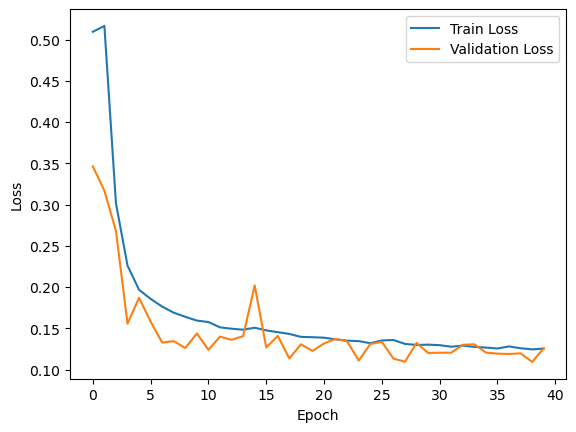

In [7]:
plt.figure()
plt.plot(range(n_epochs), train_loss_list, label='Train Loss')
plt.plot(range(n_epochs), val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Anomaly detection
def predict(model, dataset, loss_function):
    predictions, losses = [], []
    with torch.no_grad():
        for seq, target in dataset:
            seq = seq.to(device).float()
            output = model(seq)
            loss = loss_function(output, seq)
            predictions.append(output.squeeze(0).cpu().numpy())
            # print(((loss)))
            losses.append(loss.item())
    return predictions, losses

model.eval()
train_predictions, train_losses = predict(model, train_loader, criterion)
test_predictions, test_losses = predict(model, test_loader, criterion)


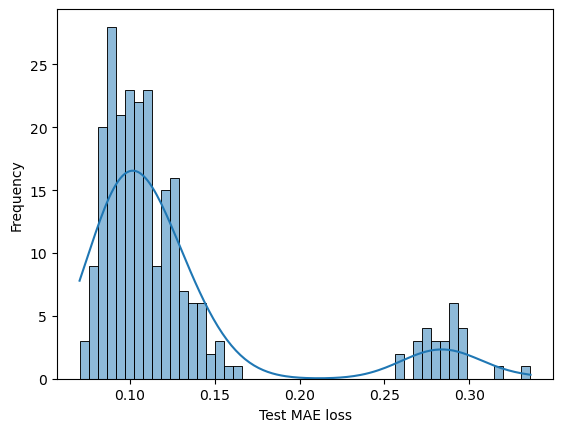

Reconstruction error threshold: 1.1103100776672363


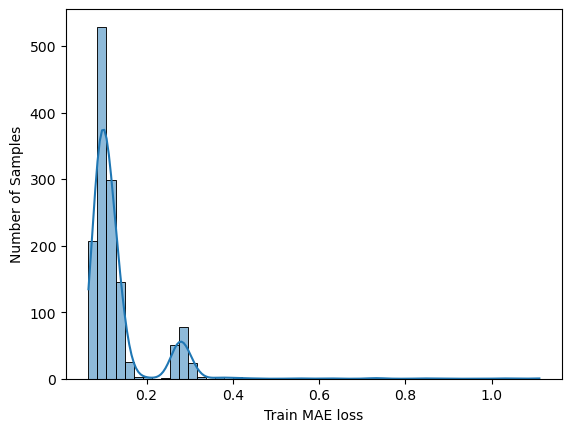

In [8]:
sns.histplot(test_losses, bins=50, kde=True)
plt.xlabel('Test MAE loss')
plt.ylabel('Frequency')
plt.show()

threshold = np.max(train_losses)
print(f'Reconstruction error threshold: {threshold}')

# plt.figure()
sns.histplot(train_losses, bins=50, kde=True)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')
plt.show()

In [9]:
def compute_anomaly_scores_full(model, X, y, loss_function, time_steps):
    model.eval()
    scores = []
    with torch.no_grad():
        for i in range(len(X)):
            seq = torch.tensor(X[i:i+1], dtype=torch.float32).to(device)  # Shape (1, time_steps, input_size)
            output = model(seq)
            loss = loss_function(output, seq)
            scores.append(loss.item())
    return scores

# Prepare the full dataset for prediction
full_X = np.concatenate([X_train, X_test], axis=0)
full_y = np.concatenate([y_train, y_test], axis=0)

# Compute anomaly scores for the full dataset
anomaly_scores = compute_anomaly_scores_full(model, full_X, full_y, criterion, TIME_STEPS)

In [34]:
THRESHOLD = 0.4

# test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
# test_score_df['loss'] = test_losses
# test_score_df['threshold'] = THRESHOLD
# test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
# test_score_df['data_0'] = test[TIME_STEPS:].data_0

In [22]:
len(anomaly_scores)

51720

In [20]:
data

,data_0,data_1,anomalies
datetime,,,
2023-01-01 00:00:00,21.719925,19.925141,False
2023-01-01 00:05:00,21.357656,19.671888,False
2023-01-01 00:10:00,20.178934,19.543689,False
2023-01-01 00:15:00,19.197688,18.872886,False
2023-01-01 00:20:00,20.098658,19.599005,False
...,...,...,...
2023-06-29 23:35:00,19.636588,20.640584,False
2023-06-29 23:40:00,20.692796,19.895390,False
2023-06-29 23:45:00,20.081966,20.584634,False


In [35]:
data['anomalies'] = False
boolean_list = [score > THRESHOLD for score in anomaly_scores]
# data.loc[data.index[-len(anomaly_scores):], 'anomalies'] = boolean_list
data.iloc[-len(anomaly_scores):, data.columns.get_loc('anomalies')] = boolean_list
# Print some example anomalies
print(data[data['anomalies']].head())

                        data_0     data_1  anomalies
datetime                                            
2023-01-01 11:25:00  30.338540  30.842748       True
2023-01-01 11:30:00  30.003433  30.581857       True
2023-01-03 11:20:00  29.950749  28.648794       True
2023-01-03 11:25:00  30.126841  28.971252       True
2023-01-03 11:30:00  30.251554  29.148676       True


In [32]:
data[data['anomalies']==True]

,data_0,data_1,anomalies
datetime,,,
2023-01-01 11:20:00,29.600191,30.468725,True
2023-01-01 11:25:00,30.338540,30.842748,True
2023-01-01 11:30:00,30.003433,30.581857,True
2023-01-01 11:35:00,29.423693,30.058971,True
2023-01-01 11:40:00,29.730731,30.312233,True
...,...,...,...
2023-06-28 06:35:00,30.620730,29.791520,True
2023-06-28 06:40:00,30.819510,30.092227,True
2023-06-29 06:25:00,29.558777,30.166900,True


In [36]:
months = data.index.to_period('M').unique()
import plotly.subplots as sp
import plotly.graph_objs as go

plots = []
for month in months:
    monthly_data = data[data.index.to_period('M') == month]

    fig = sp.make_subplots(rows=1, cols=1, shared_xaxes=True, 
                           subplot_titles=('data_0', 'data_1', 'diff'),
                           vertical_spacing=0.03, horizontal_spacing=0.02)

    fig.add_trace(go.Scatter(x=monthly_data.index, y=monthly_data['data_0'], name='data_0', mode='lines'), row=1, col=1)
    # fig.add_trace(go.Scatter(x=monthly_data.index, y=monthly_data['data_1'], name='data_1', mode='lines'), row=2, col=1)
    # fig.add_trace(go.Scatter(x=monthly_data.index, y=monthly_data['diff'], name='diff', mode='lines'), row=3, col=1)

    # Find the indices where the difference exceeds the threshold
    anomaly_indices = monthly_data[monthly_data['anomalies']].index

    # Add markers for anomalies
    fig.add_trace(go.Scatter(x=anomaly_indices, y=monthly_data.loc[anomaly_indices, 'data_0'], 
                             mode='markers', name='Anomaly data_0', 
                             marker=dict(color='red', size=10)), row=1, col=1)
    
    # fig.add_trace(go.Scatter(x=anomaly_indices, y=monthly_data.loc[anomaly_indices, 'data_1'], 
    #                          mode='markers', name='Anomaly data_1', 
    #                          marker=dict(color='blue', size=10)), row=2, col=1)
    
    fig.update_layout(title_text=f"Data for {month}")
    plots.append(fig)

# Display the plots
for plot in plots:
    plot.show()